# Projeto 2 de Ciência dos Dados

Integrantes:
- Barbara Martins Damasceno
- Daniel Costa Delattre 
- Guilherme Augusto Carvalho

## Objetivo 
**Pergunta que queremos responder**
Qual é o preço de uma casa de acordo com suas características?

Carregando algumas bibliotecas:

In [135]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os, csv, string, re
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

In [136]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/daniel/Desktop/Materias/cdados/house-prediction-cdados


In [137]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

Verificando o diretório

Carregando a base de dados de teste e de treino:

In [138]:
dados= pd.read_csv('datacasas.csv').drop(['date'], axis=1)
#dadosteste = pd.read_csv('t1.xlsx', sheet_name='Teste')

Verificando se não existe linhas sem dados/informação

In [139]:
np.sum(dados.isnull())

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Mostrando quais são as colunas disponíveis no dataset:

In [140]:
dados.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [141]:
dados.head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


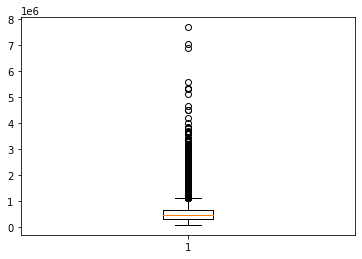

In [142]:
#Temos que ver se isso vai ser legal colocar ou não
plt.boxplot(dados['price'])
plt.show()

# Analise exploratória 

Para visualizar o comportamento de cada variável do dataset (preço, número de banheiros, números de quartos, área da casa e do seu terreno, etc) foram plotados gráficos para identificar a distribuição de cada uma delas dentro do dataset. Além disso, como a variável de interesse para prever é o preço de casas, foram plotados alguns gráficos para visualizar a interação entre a coluna de preços das casas e as demais colunas. 

## Distribuição de cada variável

Abaixo está os gráficos da distribuição de cada variável, exceto da coluna com os preços, ela será analisada posteriormente:

Text(0, 0.5, 'Lote do terreno (square feet)')

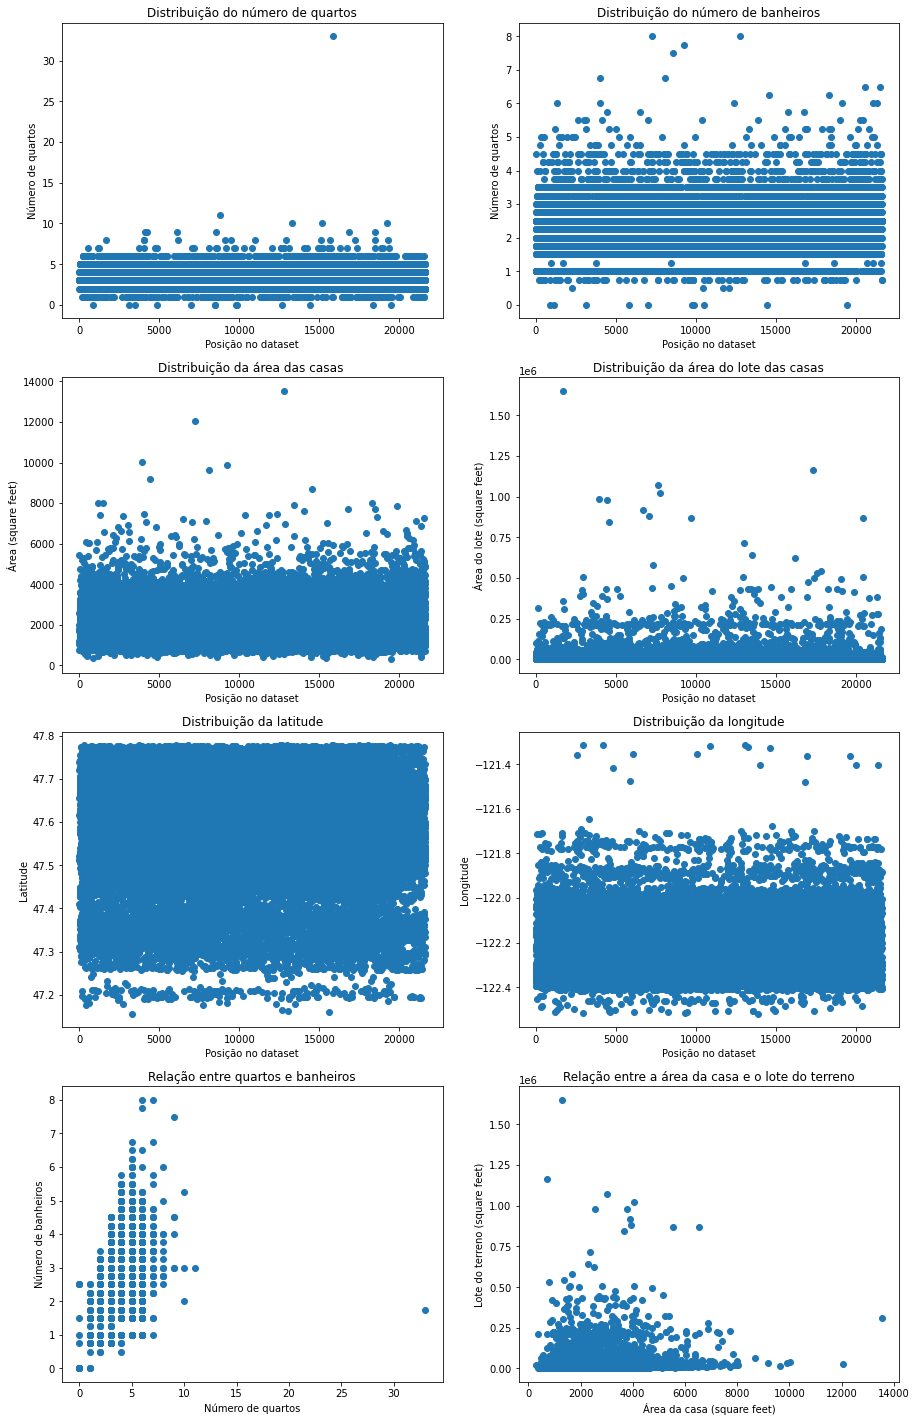

In [143]:
fig = plt.figure(figsize=(15, 25))

numero_linhas = np.arange(0,len(dados.price),1)

plt.subplot(4, 2, 1)
plt.scatter(numero_linhas,dados.bedrooms)
plt.title('Distribuição do número de quartos')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 2)
plt.scatter(numero_linhas,dados.bathrooms)
plt.title('Distribuição do número de banheiros')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 3)
plt.scatter(numero_linhas,dados.sqft_living)
plt.title('Distribuição da área das casas ')
plt.xlabel("Posição no dataset")
plt.ylabel("Área (square feet)")

plt.subplot(4, 2, 4)
plt.scatter(numero_linhas,dados.sqft_lot)
plt.title('Distribuição da área do lote das casas')
plt.xlabel("Posição no dataset")
plt.ylabel("Área do lote (square feet)")

plt.subplot(4, 2, 5)
plt.scatter(numero_linhas,dados.lat)
plt.title('Distribuição da latitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Latitude")

plt.subplot(4, 2, 6)
plt.scatter(numero_linhas,dados.long)
plt.title('Distribuição da longitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Longitude")

#Observando a relação entre o número de quartos e banheiros
plt.subplot(4,2,7)
plt.scatter(dados.bedrooms, dados.bathrooms)
plt.title('Relação entre quartos e banheiros')
plt.xlabel('Número de quartos')
plt.ylabel('Número de banheiros')

#Observando a relação entre a área da casa e o lote do terreno
plt.subplot(4,2,8)
plt.scatter(dados.sqft_living, dados.sqft_lot)
plt.title('Relação entre a área da casa e o lote do terreno')
plt.xlabel('Área da casa (square feet)')
plt.ylabel('Lote do terreno (square feet)')

Agora, iremos analisar a coluna do preço:

Text(0, 0.5, 'Preço da casa')

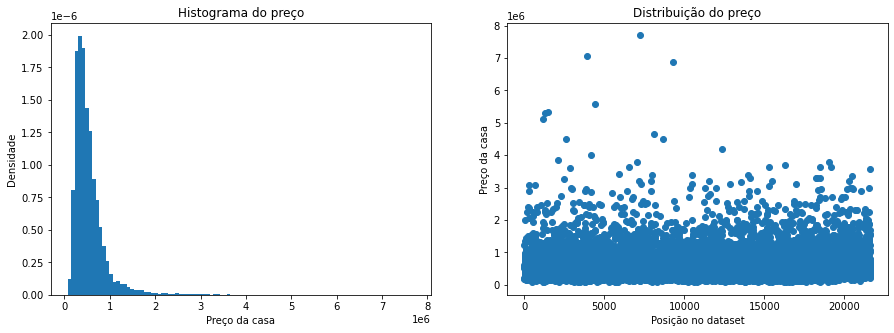

In [144]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(dados.price,bins=100,density=True)
plt.title('Histograma do preço')
plt.ylabel('Densidade')
plt.xlabel('Preço da casa')

plt.subplot(1, 2, 2)
faixa_aleatoria = np.arange(0,len(dados.price),1)
plt.scatter(faixa_aleatoria,dados.price)
plt.title('Distribuição do preço')
plt.xlabel('Posição no dataset')
plt.ylabel('Preço da casa')

#### Histograma do preço
O histograma se trata de gráfico que apresenta a distribuição de acordo com a frequência de uma amostra. Pode-se perceber que o histograma está deslocado a esquerda, mostrando que os preços dos dados se concentram até 1.000.000

#### Distribuição do preço
Esse gráfico cada ponto representa o valor de cada casa. Nele também percebe-se a concentração bem acentuada na faixa de 1 milhões e uma concentração mais leve entre 1 milhão e 2 milhões.

Como a variável de interesse para se prever é o preço, foi plotado gráficos cruzando os dados do preço com outras colunas:

Text(0, 0.5, 'Área do terreno')

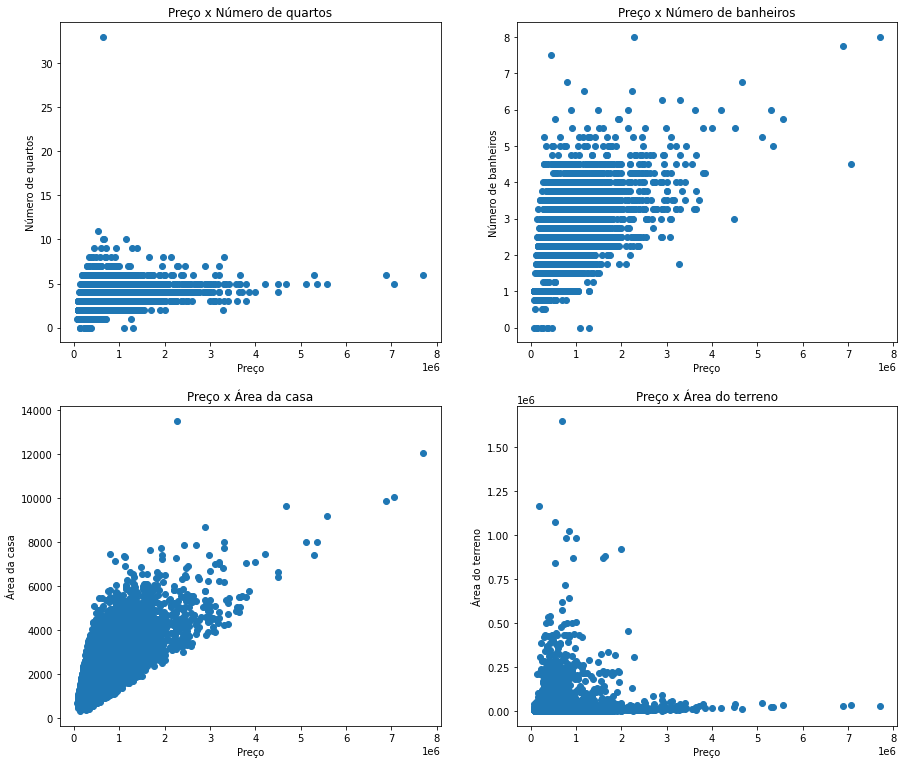

In [145]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 20))

plt.subplot(3,2,3)
plt.scatter(dados.price, dados.bedrooms)
plt.title('Preço x Número de quartos')
plt.xlabel('Preço')
plt.ylabel('Número de quartos')

plt.subplot(3,2,4)
plt.scatter(dados.price, dados.bathrooms)
plt.title('Preço x Número de banheiros')
plt.xlabel('Preço')
plt.ylabel('Número de banheiros')

plt.subplot(3,2,5)
plt.scatter(dados.price, dados.sqft_living)
plt.title('Preço x Área da casa')
plt.xlabel('Preço')
plt.ylabel('Área da casa')

plt.subplot(3,2,6)
plt.scatter(dados.price, dados.sqft_lot)
plt.title('Preço x Área do terreno')
plt.xlabel('Preço')
plt.ylabel("Área do terreno")

# Predição por Regressão Linear Multipla

~Explicar sobre o que é e como funciona o método

Definindo variável de interesse (preço) e demais que serão base para a predição

In [146]:
X = dados[['bedrooms', 'bathrooms', 'sqft_living','waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']]
Y = dados['price']

In [147]:
X.corr()

,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
bedrooms,1.000000,0.515884,0.576671,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.008931,0.129473
bathrooms,0.515884,1.000000,0.754665,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042
sqft_living,0.576671,0.754665,1.000000,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223
waterfront,-0.006582,0.063744,0.103818,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,-0.014274,-0.041910
view,0.079532,0.187737,0.284611,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.006157,-0.078400
condition,0.028472,-0.124982,-0.058753,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,-0.014941,-0.106500
grade,0.356967,0.664983,0.762704,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372
sqft_above,0.477600,0.685342,0.876597,0.072075,0.167649,-0.158214,0.755923,1.000000,-0.051943,0.423898,0.023285,-0.000816,0.343803
sqft_basement,0.303093,0.283770,0.435043,0.080588,0.276947,0.174105,0.168392,-0.051943,1.000000,-0.133124,0.071323,0.110538,-0.144765
yr_built,0.154178,0.506019,0.318049,-0.026161,-0.053440,-0.361417,0.446963,0.423898,-0.133124,1.000000,-0.224874,-0.148122,0.409356


In [148]:
results = regress(X,Y)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4085.
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:53:39   Log-Likelihood:            -2.9480e+05
No. Observations:               21613   AIC:                         5.896e+05
Df Residuals:                   21600   BIC:                         5.897e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.561e+07   1.49e+06    -23.825      0.000   -3.85e+07   -3.27e+07
bedrooms      -3.404e+04   1992.714    -17.082      0.000   -3.79e+04   -3.01e+04
bathrooms      4.017e+04   3570.215     11.252      0.000    3.32e+04    4.72e+04
sqft_living    7.252e+13   8.61e+13      0.842      0.400   -9.63e+13    2.41e+14
waterfront     5.835e+05   1.75e+04     33.323      0.000    5.49e+05    6.18e+05
view           5.167e+04   2123.855     24.328      0.000    4.75e+04    5.58e+04
condition      3.043e+04   2351.877     12.937      0.000    2.58e+04     3.5e+04
grade          1.023e+05   2075.882     49.267      0.000    9.82e+04    1.06e+05
sqft_above    -7.252e+13   8.61e+13     -0.842      0.400   -2.41e+14    9.63e+13
sqft_basement -7.252e+13   8.61e+13     -0.842      0.400   -2.41e+14    9.63e+13
yr_built      -2471.7735     70.930    -34.848      0.000   -2610.802   -2332.745
yr_renovated     19.8061      3.677      5.386      0.000      12.598      27.014
lat            5.656e+05   1.05e+04     53.999      0.000    5.45e+05    5.86e+05
long          -1.052e+05   1.13e+04     -9.318      0.000   -1.27e+05   -8.31e+04
==============================================================================
Omnibus:                    18276.691   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1756277.833
Skew:                           3.551   Prob(JB):                         0.00
Kurtosis:                      46.587   Cond. No.                     3.82e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.85e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Análise da tabela

Falar da relevância das variáveis escolhidas, R², prob e etc...

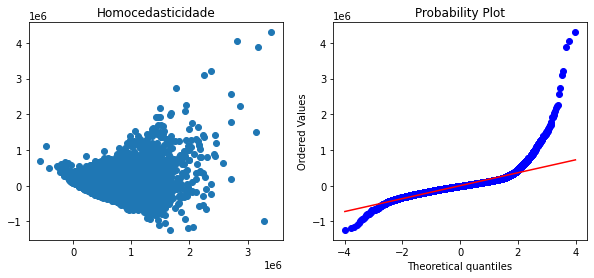

In [149]:
resultado_reg = results.resid

y_predict = results.predict(sm.add_constant(X))

fig1 = plt.figure(figsize=(10, 4))

#Verificando a Homocedasticidade
plt.subplot(1,2,1)
plt.scatter(y_predict,resultado_reg)
plt.title("Homocedasticidade")

#Verificando se os resultados obtidos por regressão apresentam distribuição normal
plt.subplot(1,2,2)
stats.probplot(resultado_reg,dist='norm',plot=plt)
plt.show()

Percebe-se que os valores preditos não seguem a distribuição normal e que a homocedasticidade varia.

# Predição por Decision Tree Regressor

~Explicar sobre o que é e como funciona o método

Escolhendo as colunas que serão usadas como parâmetros:

In [150]:
features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'lat', 'long',]

Renomeando quem será a variável de interesse (preço) e as features. Além de separar o banco de dados entre teste e treinamento:

In [151]:
y = dados.price
x = dados[features]
xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)

In [152]:
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)

DecisionTreeRegressor()

In [153]:
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
print(f'MAE: {val_mae:.2f}')

MAE: 99631.01


# Predição por Random Forest

~Explicar sobre o que é e como funciona o método

In [154]:
#modelo usando random forest 
modelo_randomforest = RandomForestRegressor(random_state=1)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)

print(f'Random Forest MAE: {rf_mae:.2f}')

Random Forest MAE: 71013.02


Esse gŕafico mostra a relação entre os valores previstos e os valores reais

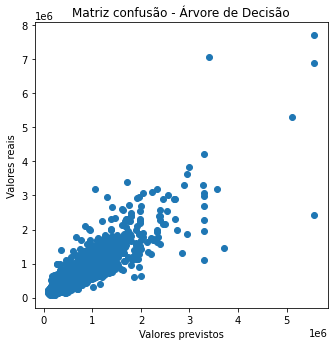

In [155]:
fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(val_predictions,yvalidacao)
plt.title("Matriz confusão - Árvore de Decisão")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()

In [156]:
#removendo outliers
train = dados.copy()
clf = IsolationForest(max_samples = 250, random_state = 42)
clf.fit(train)
y_semout = clf.predict(train)
y_semout = pd.DataFrame(y_semout, columns = ['Top'])
y_semout[y_semout['Top'] == 1].index.values
train = train.iloc[y_semout[y_semout['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_semout[y_semout['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])
train.drop('id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

Number of Outliers: 2166
Number of rows without outliers: 19447


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
5,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
6,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
7,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
8,662500.0,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
9,468000.0,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000


Testando Decision Tree sem outliers

In [179]:
dados = train
y = dados.price
x = dados[features]
xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
print(f'MAE Decision Tree sem outliers: {val_mae:.2f}')

MAE Decision Tree sem outliers: 79960.35


Random Forest sem outliers

In [190]:
#modelo usando random forest 
modelo_randomforest = RandomForestRegressor(random_state=1,n_jobs=6,n_estimators=1000,min_samples_split=5,min_samples_leaf=2,max_features='auto',max_depth=50,bootstrap=True)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)

print(f'Random Forest MAE sem outliers: {rf_mae:.2f}')

Random Forest MAE sem outliers: 56424.22


In [163]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(modelo_randomforest.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [169]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [182]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -2)
# # Fit the random search model
# rf_random.fit(xtreino, ytreino)

In [171]:
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [183]:
dic = {'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [188]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: ${:0.2f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    # rf_random.fit(xtreino, ytreino)
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(xtreino, ytreino)
base_accuracy = evaluate(base_model, xtreino, ytreino)

Model Performance
Average Error: $24475.87 .
Accuracy = 94.65%.


In [189]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, xtreino, ytreino)

Model Performance
Average Error: $25647.95 .
Accuracy = 94.32%.


In [187]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.35%.
